## How to access STAC Collections from the private STAC API at terrabyte - using Planet Fusion as example

### Requirements:

1. You need access rights to the DSS container with the Planet Fusion data (pn56su-dss-0030).
2. Before you start querying the private STAC API with the [`terrapi-client`](https://github.com/DLR-terrabyte/terrapi-client) lib, you need to authentificate yourself with the [terrapi cli](https://docs.terrabyte.lrz.de/software/tools/terrapi/usage/terrapi/stac/auth/): ```terrapi stac auth```

In [69]:
import pystac
from odc import stac as odc_stac
import dask
import time
import xarray
from dask.distributed import Client
import folium
import folium.plugins as folium_plugins
import geopandas as gpd
from odc.geo import geobox
from terrapi.client.stac import open_private_catalog

In [55]:
# Connect to the terrabyte private STAC API
catalog = open_private_catalog()


bbox = [10, 49.8, 10, 49.8] 
date = ["2024-01-01", "2024-01-31"]
query = {
    
}

results = catalog.search(
    collections=[f"pn56su-dss-0030.PF_SR"],
    datetime=date,
    bbox=bbox,
)
items = results.item_collection_as_dict()
print("%s items found" % len(items['features']))

30 items found


## Inspect STAC Items

In [56]:
items = list(results.items())

In [57]:
items[0]

<Item id=32N_23E-229N_2024-01-31>

In [58]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)
fullscreen = folium_plugins.Fullscreen()
style = {'fillColor': '#00000000', "color": "#0000ff", "weight": 1}

footprints = folium.GeoJson(
    gpd.GeoDataFrame.from_features([item.to_dict() for item in items]).to_json(),
    name='Stac Item footprints',
    style_function=lambda x: style,
    control=True
)

footprints.add_to(map)
layer_control.add_to(map)
fullscreen.add_to(map)
map.fit_bounds(map.get_bounds())
map

## Load the Surface Reflectance asset (sr) into a xarray datacube

In [60]:
dask_chunksize=1024
cube = odc_stac.load(
    items,
    bands=['nir', 'red'],
    chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
    anchor=geobox.AnchorEnum.FLOATING  # preserve original pixel grid
)

# temporal chunking
cube = cube.chunk(chunks={'time': -1})

# write CF-compliant CRS representation
#cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)

cube

<xarray.Dataset> Size: 8GB
Dimensions:      (y: 8000, x: 8000, time: 30)
Coordinates:
  * y            (y) float64 64kB 5.52e+06 5.52e+06 ... 5.496e+06 5.496e+06
  * x            (x) float64 64kB 5.52e+05 5.52e+05 ... 5.76e+05 5.76e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 240B 2024-01-01 2024-01-03 ... 2024-01-31
Data variables:
    nir          (time, y, x) int16 4GB dask.array<chunksize=(30, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) int16 4GB dask.array<chunksize=(30, 1024, 1024), meta=np.ndarray>

In [61]:
cube["ndvi"]=(cube.nir - cube.red)/(cube.nir + cube.red)
cube


<xarray.Dataset> Size: 23GB
Dimensions:      (y: 8000, x: 8000, time: 30)
Coordinates:
  * y            (y) float64 64kB 5.52e+06 5.52e+06 ... 5.496e+06 5.496e+06
  * x            (x) float64 64kB 5.52e+05 5.52e+05 ... 5.76e+05 5.76e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 240B 2024-01-01 2024-01-03 ... 2024-01-31
Data variables:
    nir          (time, y, x) int16 4GB dask.array<chunksize=(30, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) int16 4GB dask.array<chunksize=(30, 1024, 1024), meta=np.ndarray>
    ndvi         (time, y, x) float64 15GB dask.array<chunksize=(30, 1024, 1024), meta=np.ndarray>

## Define the computation

In [62]:
median = (cube.quantile(0.5, dim='time', skipna=True, keep_attrs=True)
          .rename({b: f'{b}_median' for b in list(cube.keys())}))
median

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 8000, x: 8000)
Coordinates:
  * y            (y) float64 64kB 5.52e+06 5.52e+06 ... 5.496e+06 5.496e+06
  * x            (x) float64 64kB 5.52e+05 5.52e+05 ... 5.76e+05 5.76e+05
    quantile     float64 8B 0.5
Data variables:
    nir_median   (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi_median  (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

## Start the dask client

In [63]:
import os
dir_out = '~/xarray-dask-tutorial'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
# from testins running without threads is the faster option 
dask_threads = 1

In [64]:

host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status'
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
dask.config.set({'distributed.comm.timeouts.tcp': '180s',
                 'distributed.comm.timeouts.connect': '120s',
                 'distributed.dashboard.graph-max-items': 55000,
                 'distributed.deploy.lost-worker-timeout': '90s',
                 'distributed.scheduler.allowed-failures': 180,
                 })
#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client


INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46879
INFO:distributed.scheduler:  dashboard at:  https://portal.terrabyte.lrz.de/node/hpdar03c02s07.cos.lrz.de/55771/proxy/40365/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40067'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42345'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33131'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:36637'


INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36083 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36083
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60600
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36553 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36553
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60606
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36929 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36929
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60584
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36241 name: 2
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36241
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60572
INFO:distributed.scheduler:Receive client co

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s07.cos.lrz.de/55771/proxy/40365/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s07.cos.lrz.de/55771/proxy/40365/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46879,Workers: 4
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s07.cos.lrz.de/55771/proxy/40365/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36083,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s07.cos.lrz.de/55771/proxy/34093/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:40067,


## Start the computation

In [65]:
%%time

filename = os.path.join(dir_out, "PlanetFusion_median.zarr")
#ignore invalid value encountered in divide warning (ndvi divide by zero)
delayed = median.to_zarr(filename, mode='w', compute=False, consolidated=True)
dask.compute(delayed)



/dss/dsshome1/08/di93cof/micromamba/envs/stac_analysis/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 30.2 s, sys: 4.64 s, total: 34.8 s
Wall time: 3min 53s


(None,)

In [67]:
client.cluster.close()
time.sleep(5)
client.close()

## Load and Visualize the result from File

In [70]:
result = xarray.open_zarr(filename)
result

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 8000, x: 8000)
Coordinates:
  * y            (y) float64 64kB 5.52e+06 5.52e+06 ... 5.496e+06 5.496e+06
  * x            (x) float64 64kB 5.52e+05 5.52e+05 ... 5.76e+05 5.76e+05
    quantile     float64 8B ...
Data variables:
    nir_median   (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi_median  (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    red_median   (y, x) float64 512MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

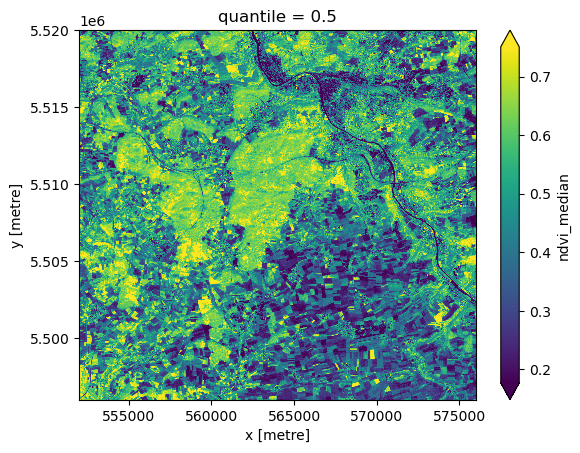

In [71]:
result.ndvi_median.plot(robust=True)